# California Housing Regression Project

In this project we will build a model to predict housing prices based on location, median income, and number of rooms per house using linear regression. The data is taken from the 1990 census. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns

#data is from https://www.kaggle.com/camnugent/california-housing-prices/data

First we clean the data and split it into training and testing sets.

In [3]:
df = pd.read_csv("CA_housing.csv")
df = df.drop(columns = ['total_bedrooms'])
df['rooms_per_house'] = df['total_rooms']/df['population']
df.drop(df[df['median_house_value'] > 490000].index, inplace = True)

df.drop(['ocean_proximity','households', 'housing_median_age', 'total_rooms', 'population'], axis=1, inplace=True)

#drop longitude outliers
df = df[df['longitude'] < (np.max(df['longitude']) - 2.3)]
df = df[df['longitude'] > (np.min(df['longitude']) + 1)]

df = df[df['rooms_per_house'] < 5]

X = df.drop(columns = ['median_house_value'])
Y = df['median_house_value']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(15176, 4)
(3794, 4)
(15176,)
(3794,)


In [4]:
# sort by lattitude
lat_vs_price = pd.DataFrame(np.c_[X_train['latitude'], Y_train]).to_numpy()
lat_vs_price = lat_vs_price[lat_vs_price[:,0].argsort()]

#sort by longitude
lon_vs_price = pd.DataFrame(np.c_[X_train['longitude'], Y_train]).to_numpy()
lon_vs_price = lon_vs_price[lon_vs_price[:,0].argsort()]

## Price vs. Coordinates

To find a correlation between price and geographic location, we will use a polynomial fit.

-----------------------------------
RMSE for latitude is 90209.59727084661
R^2 Score for latitude is 0.12513775202562893

RMSE for longitude is 89986.94453925984
R^2 Score for longitude is 0.12945104211990976



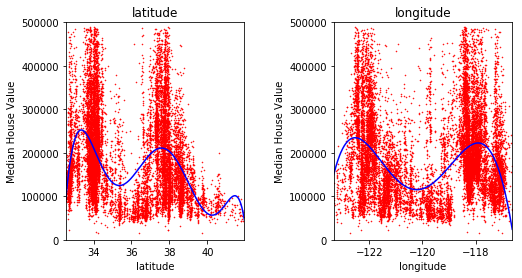

In [5]:
X_lat = lat_vs_price[:,0] 
y_lat = lat_vs_price[:,1]

X_lon = lon_vs_price[:,0] 
y_lon = lon_vs_price[:,1]

print("-----------------------------------")
plt.figure(figsize=[8,4])
for i, coor, X, y in [[1, 'latitude', X_lat, y_lat],[2, 'longitude', X_lon, y_lon]]:
    poly_reg=PolynomialFeatures(degree=9)
    X_poly=poly_reg.fit_transform(X[:,np.newaxis])
    poly_reg.fit(X_poly, y[:, np.newaxis])
    lin_reg2=LinearRegression()

    lin_reg2.fit(X_poly, y[:, np.newaxis])

    y_poly_pred=lin_reg2.predict(X_poly)
    
    rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
    r2 = r2_score(y,y_poly_pred)
    print('RMSE for {} is {}'.format(coor, rmse))
    print('R^2 Score for {} is {}'.format(coor, r2))
    print('')

    plt.subplot(1, 2, i)
    plot = plt.scatter(X,y,color='red', s=0.3)
    plt.axis([np.min(X), np.max(X), 0, 500000])
    plt.plot(X,lin_reg2.predict(poly_reg.fit_transform(X[:,np.newaxis])),color='blue')
    plt.title(coor)
    plt.xlabel(coor)
    plt.ylabel('Median House Value')
    
plt.subplots_adjust(wspace=0.5)
plt.show()

The above plots show how the curves approximately capture the trends in the data. Here, we fit the data to polynomials of degree n=9. To confirm the appropriate polynomial degree, we test for convergence with respect to $R^{2}$ and RMSE. 

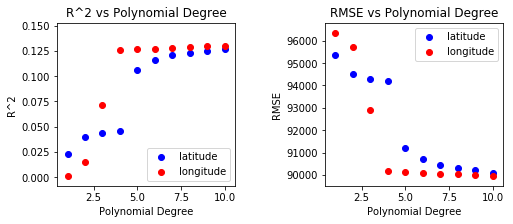

In [6]:
r2_v_deg_lat = []
rmse_v_deg_lat = []
r2_v_deg_lon = []
rmse_v_deg_lon = []
deg = range(1,11)



for r2_v_deg, rmse_v_deg, X, y in [[r2_v_deg_lat, rmse_v_deg_lat, X_lat, y_lat],
                                   [r2_v_deg_lon, rmse_v_deg_lon, X_lon, y_lon]]:
    for i in range (1,11):
        poly_reg=PolynomialFeatures(degree=i)
        X_poly=poly_reg.fit_transform(X[:,np.newaxis])
        poly_reg.fit(X_poly, y[:, np.newaxis])
        lin_reg2=LinearRegression()
        lin_reg2.fit(X_poly, y[:, np.newaxis])

        y_poly_pred=lin_reg2.predict(X_poly)

        rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
        r2 = r2_score(y,y_poly_pred)
        r2_v_deg.append(r2)
        rmse_v_deg.append(rmse)

plt.figure(figsize=[8,3])
    
plt.subplot(1, 2, 1)
plt.scatter(deg, r2_v_deg_lat, color='blue')
plt.scatter(deg, r2_v_deg_lon, color='red')
plt.legend(["latitude", "longitude"], loc=4)
plt.title('R^2 vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('R^2')

plt.subplot(1, 2, 2)
plt.scatter(deg, rmse_v_deg_lat, color='blue')
plt.scatter(deg, rmse_v_deg_lon, color='red')
plt.legend(["latitude", "longitude"], loc=1)
plt.title('RMSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')

plt.subplots_adjust(wspace=0.5)

plt.show()

The results show that a degree of n=9 is appropriate. 

## Price vs. Median Income

Next we will use a simple linear regression for median income data. 

In [7]:
poly_reg=PolynomialFeatures(degree=9)
X_poly_lat=poly_reg.fit_transform(X_lat[:,np.newaxis])
X_poly_lon=poly_reg.fit_transform(X_lon[:,np.newaxis])
poly_reg.fit(X_poly_lat, y_lat[:, np.newaxis])
poly_reg.fit(X_poly_lon, y_lon[:, np.newaxis])

X_poly_lat_test=poly_reg.fit_transform(X_test.latitude[:,np.newaxis])
X_poly_lon_test=poly_reg.fit_transform(X_test.longitude[:,np.newaxis])

lin_reg_lat=LinearRegression()
lin_reg_lon=LinearRegression()

lin_reg_lat.fit(X_poly_lat, y[:, np.newaxis])
Y_predict_lat = lin_reg_lat.predict(X_poly_lat_test)

lin_reg_lon.fit(X_poly_lon, y[:, np.newaxis])
Y_predict_lon = lin_reg_lon.predict(X_poly_lon_test)

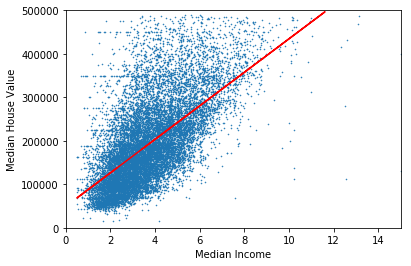

In [8]:
lin_reg_income = LinearRegression()
lin_reg_income.fit(X_test.median_income[:,np.newaxis], Y_test.values)
Y_predict_income = lin_reg_income.predict(X_test.median_income[:,np.newaxis])

plt.scatter(X_train.median_income, Y_train.values, s=0.3)
plt.plot(X_test.median_income, Y_predict_income, color = 'red')
plt.axis([0,15,0,500000])
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.show()

This looks like a clean trend. 

## Number of Rooms vs. Price

Let's do the same thing for the number of rooms per house. 

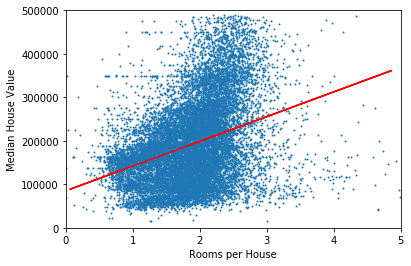

In [9]:
lin_reg_rooms = LinearRegression()
lin_reg_rooms.fit(X_test.rooms_per_house[:,np.newaxis], Y_test.values)
Y_predict_rooms = lin_reg_rooms.predict(X_test.rooms_per_house[:,np.newaxis])

plt.scatter(X_train.rooms_per_house, Y_train.values, s=1)
plt.plot(X_test.rooms_per_house, Y_predict_rooms, color = 'red')
plt.axis([0,5,0,500000])
plt.xlabel('Rooms per House')
plt.ylabel('Median House Value')
plt.show()

Now to make a prediction, we will average the four predicted values and assess their accuracy against the testing data. 

In [10]:
Y_predict_final = []

for i in range(len(Y_predict_lat)):
    Y_predict_final.append(((Y_predict_lat[i]) + (Y_predict_lon[i]) +
                                                     Y_predict_income.tolist()[i] + Y_predict_rooms.tolist()[i])/4)
Y_predict_final = pd.DataFrame(Y_predict_final)


In [11]:
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_predict_final))
r2_test = r2_score(Y_test, Y_predict_final)
    
print('RMSE for testing set is {}'.format(rmse_test))
print('R^2 Score for testing set is {}'.format(r2_test))

RMSE for testing set is 79940.44253554166
R^2 Score for testing set is 0.27690671416397084


An $R^{2}$ value of 0.27 means approximately 27% of the variance in the data can be explained by the model. This is far from accurate, but it's better than guessing!